In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from src.ds import Dataset, collate_fn
from torch.utils.data import DataLoader
import time

Intentando acelerar el data loading...

In [3]:
train = pd.read_json('data/train.json')

In [7]:
ds = Dataset(
	train.filename.values, 
	(0, 1),
	(2,1,0), 
	['September', 'October', 'November', 'December', 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August'], 
	train.label.values,
	use_ndvi=True,
	use_ndwi=True,
	use_clouds=True,
)

In [8]:
# measure time to load data

results = []
num_batches = 100
# con 12 meses peta a partir de bs 16
for bs in [1, 2, 4, 8]: #, 16, 32, 64]:
	dl = DataLoader(ds, batch_size=bs, shuffle=True, num_workers=10, pin_memory=True, collate_fn=collate_fn)
	start = time.time()
	for i, batch in enumerate(dl):
		(s1, s2), y = batch
		s1, s2 = s1.cuda(), s2.cuda()
		# s1, s2 = s1.cuda(non_blocking=True), s2.cuda(non_blocking=True)
		if i == num_batches:
			break
	end = time.time()
	print(f'100 batches loaded in {end-start:.2f} seconds')
	results.append((bs, end-start))

100 batches loaded in 2.43 seconds
100 batches loaded in 4.47 seconds
100 batches loaded in 10.70 seconds
100 batches loaded in 36.45 seconds


In [6]:
from src.ds import Dataset2

train2 = pd.read_csv('data/train_chip_ids.csv')
ds = Dataset2(train2.chip_id.values)

results = []
num_batches = 100
# con 12 meses peta a partir de bs 16
for bs in [1, 2, 4, 8]: #, 16, 32, 64]:
	dl = DataLoader(ds, batch_size=bs, shuffle=True, num_workers=10, pin_memory=True)
	start = time.time()
	for i, batch in enumerate(dl):
		s1, s2, y = batch
		s1, s2 = s1.cuda(), s2.cuda()
		# s1, s2 = s1.cuda(non_blocking=True), s2.cuda(non_blocking=True)
		if i == num_batches:
			break
	end = time.time()
	print(f'100 batches loaded in {end-start:.2f} seconds')
	results.append((bs, end-start))

100 batches loaded in 1.33 seconds
100 batches loaded in 2.46 seconds
100 batches loaded in 4.56 seconds
100 batches loaded in 8.96 seconds


Mejor! Pero podemos ir más allá?

In [11]:
import cupy as cp
from random import shuffle

class ExternalInputIterator(object):
    def __init__(self, chip_ids, batch_size, shuffle=False):
        self.batch_size = batch_size
        self.chip_ids = chip_ids
        self.sensors = ['S1', 'S2']
        self.shuffle = shuffle
        self.data_set_len = len(chip_ids)
        self.n = len(self.chip_ids)

    def __iter__(self):
        self.i = 0
        if self.shuffle:
            shuffle(self.chip_ids)
        return self

    def __next__(self):
        if self.i >= self.n:
            self.__iter__()
            raise StopIteration
        batch1, batch2, labels = [], [], []
        for _ in range(self.batch_size):
            chip_id = self.chip_ids[self.i % self.n]
            x1 = cp.load(
                f'data/train_features_npy/{chip_id}_S1.npy')
            x2 = cp.load(
                f'data/train_features_npy/{chip_id}_S2.npy')
            batch1.append(x1)
            batch2.append(x2)
            label = cp.load(f'data/train_agbm_npy/{chip_id}.npy')
            label = label[..., None]
            labels.append(label)
            self.i += 1
        return (batch1, batch2, labels)

    def __len__(self):
        return self.data_set_len

    next = __next__

In [12]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types

train = pd.read_csv('data/train_chip_ids.csv')
batch_size = 4
eii = ExternalInputIterator(
	train.chip_id.values, 
	batch_size
)

x1, x2, labels = next(iter(eii))

In [13]:
x1[0].shape, x2[0].shape, labels[0].shape

((12, 256, 256, 2), (12, 256, 256, 6), (256, 256, 1))

In [14]:
batch_size = 4
pipe = Pipeline(batch_size=batch_size, num_threads=2, device_id=0)
seed = 1
trans = False
with pipe:
    x1, x2, labels = fn.external_source(source=eii, num_outputs=3, device="gpu", dtype=types.FLOAT)
    # if trans:
    #     x1 = fn.flip(x1, horizontal=fn.random.coin_flip(seed=seed), vertical=fn.random.coin_flip(seed=seed))
    #     x2 = fn.flip(x2, horizontal=fn.random.coin_flip(seed=seed), vertical=fn.random.coin_flip(seed=seed))
    #     labels = fn.flip(labels, horizontal=fn.random.coin_flip(seed=seed), vertical=fn.random.coin_flip(seed=seed))
    #     x1 = fn.rotate(x1, angle=90*fn.random.uniform(values=[0,1,2,3], seed=seed))
    #     x2 = fn.rotate(x2, angle=90*fn.random.uniform(values=[0,1,2,3], seed=seed))
    #     labels = fn.rotate(labels, angle=90*fn.random.uniform(values=[0,1,2,3], seed=seed))
    #     # axis = fn.random.uniform(values=[0,1], seed=seed)
    #     # x1 = fn.transpose(x1, perm=[0,1+axis,2-axis,3])
    pipe.set_outputs(x1, x2, labels)

pipe.build()

In [15]:
pipe_out = pipe.run()
pipe_out

(TensorListGPU(
     [[[[[0.42642784 0.60205966]
         [0.46515542 0.6599043 ]
         ...
         [0.29797798 0.5564118 ]
         [0.30800146 0.56191474]]
 
        [[0.44248462 0.63242173]
         [0.4735455  0.69412774]
         ...
         [0.31310946 0.5612534 ]
         [0.33922395 0.5804157 ]]
 
        ...
 
        [[0.36348388 0.5430358 ]
         [0.3672495  0.5442546 ]
         ...
         [0.3952591  0.5477305 ]
         [0.36543268 0.56297034]]
 
        [[0.38546023 0.59100145]
         [0.3808958  0.597639  ]
         ...
         [0.39770922 0.5592405 ]
         [0.39180785 0.556085  ]]]
 
 
       [[[0.39542863 0.64275837]
         [0.41169363 0.655473  ]
         ...
         [0.3334917  0.57787025]
         [0.33702204 0.59604675]]
 
        [[0.38069034 0.6191727 ]
         [0.41218606 0.6394169 ]
         ...
         [0.34605423 0.58779657]
         [0.35615087 0.5917462 ]]
 
        ...
 
        [[0.3358727  0.56132287]
         [0.33568603 0.5593278 ]

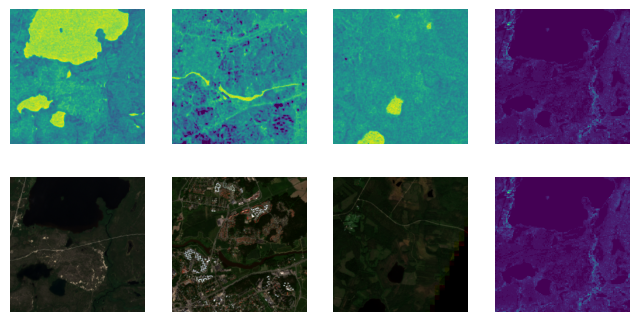

In [16]:
import matplotlib.pyplot as plt

s1s, s2s, labels = pipe_out
s1s, s2s, labels = s1s.as_cpu(), s2s.as_cpu(), labels.as_cpu()

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(2, 4, 1)
ax.imshow(s1s.at(0)[0][...,0])
ax.axis('off')
ax = fig.add_subplot(2, 4, 2)
ax.imshow(s1s.at(1)[1][...,0])
ax.axis('off')
ax = fig.add_subplot(2, 4, 3)
ax.imshow(s1s.at(2)[2][...,0])
ax.axis('off')
ax = fig.add_subplot(2, 4, 4)
ax.imshow(labels.at(0))
ax.axis('off')
ax = fig.add_subplot(2, 4, 5)
ax.imshow(s2s.at(0)[10][...,:3])
ax.axis('off')
ax = fig.add_subplot(2, 4, 6)
ax.imshow(s2s.at(1)[10][...,:3])
ax.axis('off')
ax = fig.add_subplot(2, 4, 7)
ax.imshow(s2s.at(2)[10][...,:3])
ax.axis('off')
ax = fig.add_subplot(2, 4, 8)
ax.imshow(labels.at(0))
ax.axis('off')
plt.show()

In [19]:
from nvidia.dali.plugin.pytorch import DALIGenericIterator

results = []
num_batches = 100
for bs in [1, 2, 4, 8, 16]:#, 32]:#, 64]:
	eii = ExternalInputIterator(
		train.chip_id.values, 
		batch_size=bs
	)
	pipe = Pipeline(batch_size=bs, num_threads=10, device_id=0)
	with pipe:
		x1, x2, labels = fn.external_source(source=eii, num_outputs=3, device="gpu", dtype=types.FLOAT)
		pipe.set_outputs(x1, x2, labels)
	pipe.build()
	pii = DALIGenericIterator([pipe], ['s1s', 's2s', 'labels'])
	start = time.time()
	for i, data in enumerate(pii):
		batch_data = data[0]
		s1s, s2s, labels = batch_data["s1s"], batch_data["s2s"], batch_data["labels"]
		if i == num_batches:
			# print(s1s.shape, s1s.device)
			break
	end = time.time()
	print(f'100 batches loaded in {end-start:.2f} seconds')
	results.append((bs, end-start))

100 batches loaded in 0.75 seconds
100 batches loaded in 1.42 seconds
100 batches loaded in 2.99 seconds
100 batches loaded in 6.24 seconds
100 batches loaded in 17.71 seconds


Increíble speedup!